In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2025-04-12 12:16:27.360227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744460187.682779      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744460187.760843      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_data_dir='/kaggle/input/intel-image-classification/seg_train/seg_train'
test_data_dir='/kaggle/input/intel-image-classification/seg_test/seg_test'
train_data_dir = pathlib.Path(train_data_dir)
test_data_dir=pathlib.Path(test_data_dir)
 

Visualizing the image

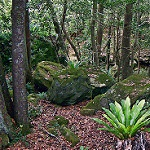

In [3]:
image_path='/kaggle/input/intel-image-classification/seg_pred/seg_pred/10092.jpg'
PIL.Image.open(str(image_path))

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  subset="training",
validation_split=0.0001,
  seed=123,
  image_size=(180, 180),
  batch_size=32)
# validation split is kept this small because we wish to consider already specified whole training data 
# for training

Found 14034 files belonging to 6 classes.
Using 14033 files for training.


I0000 00:00:1744460211.456739      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744460211.457679      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [5]:
class_names = train_ds.class_names
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  validation_split=0.999,
  subset="validation",
  seed=123,
  image_size=(180, 180),
  batch_size=32)
# there is a separate dataset for validation, so i'm not going to divide it, rather I will just use the 
# almost 100% of the validation dataset


Found 3000 files belonging to 6 classes.
Using 2997 files for validation.


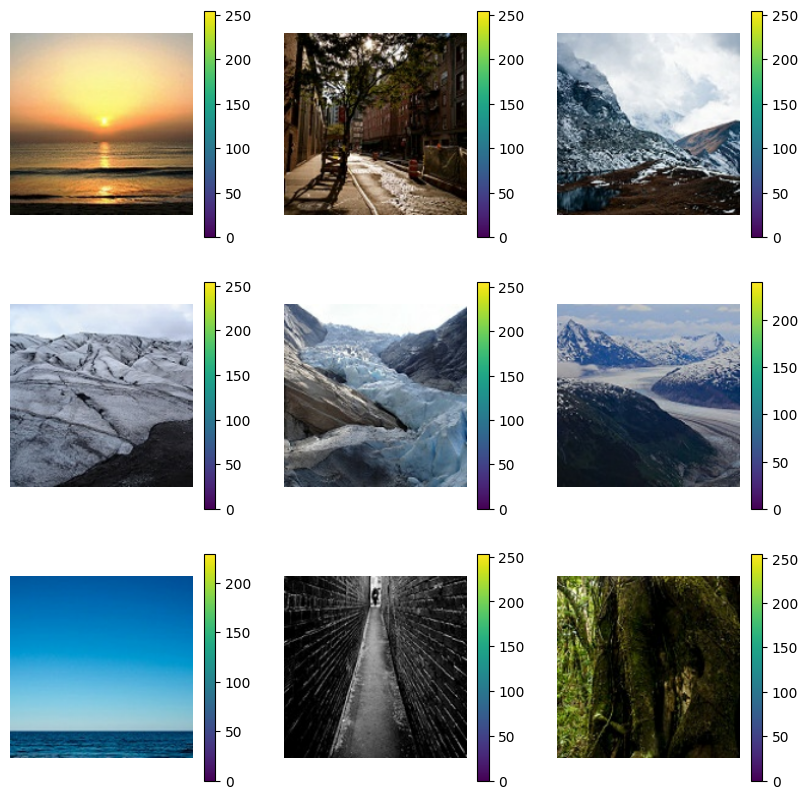

In [7]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")
    plt.colorbar()

The pixel values should be between 0 to 1

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [9]:

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
for images, labels in train_ds.take(1):
    image = tf.image.convert_image_dtype(images, tf.float32)
    
    # Find the maximum pixel value so that we can scale the pixel values between 0 to 1
    max_pixel_value = tf.reduce_max(image)
    print(max_pixel_value)
# as the maximum 

tf.Tensor(255.0, shape=(), dtype=float32)


In [11]:
data_augumentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [12]:
num_classes = 6
# defining the model
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255), # added rescaling in the first layer itself
    data_augumentation,               # added a data agumentaton layer 
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [13]:
 

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

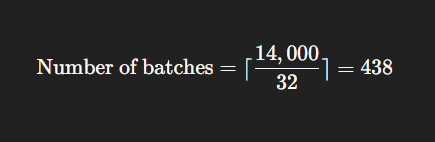
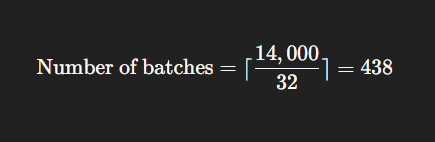

In [14]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10


I0000 00:00:1744460223.060056      72 cuda_dnn.cc:529] Loaded cuDNN version 90300


439/439 ━━━━━━━━━━━━━━━━━━━━ 33s 58ms/step - accuracy: 0.4354 - loss: 1.3544 - val_accuracy: 0.6046 - val_loss: 1.0255
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5916 - loss: 1.0564 - val_accuracy: 0.6396 - val_loss: 0.9384
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6369 - loss: 0.9629 - val_accuracy: 0.6563 - val_loss: 0.9072
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6523 - loss: 0.9157 - val_accuracy: 0.6947 - val_loss: 0.8138
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6755 - loss: 0.8635 - val_accuracy: 0.6760 - val_loss: 0.8604
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.6915 - loss: 0.8316 - val_accuracy: 0.7244 - val_loss: 0.7592
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.7032 - loss: 0.7942 - val_accuracy: 0.7147 - val_loss: 0.7742
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.7141 - loss: 0.7779 - val_accurac

**Batch Normalization:** Whenever a batch passes form one layer to other the distribution of the pixel values of the images amongst the batches changes during the training. It addresses the issue of internal covariate shift, where the distribution of inputs to a layer changes during training. By normalizing the inputs, BatchNorm ensures that each layer receives inputs with a consistent distribution, typically with zero mean and unit variance.

**Dropout**
Another technique to reduce overfitting is to introduce dropout regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.


**Model Prediction**

In [15]:

img_height, img_width=180,180
img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
This image most likely belongs to forest with a 99.91 percent confidence.
